In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
dup_chr, dup_start, dup_end = "chr02", 28000000, 32000000
depth_filter = 0.05
min_depth_norm = 1.

In [27]:
df_repeats, df_calls_hs = file_io.dfs_from_vcf(
    filename="../../data/banana/variants/SAMEA5752290_HiSeq1500_chr02_dup.vcf", 
    samples=["SAMEA5752290"], 
    vcf_format="ConSTRain"
)

df_calls_hs = df_calls_hs.dropna().merge(
    df_repeats[["str_id", "chr", "start", "end", "period"]], on="str_id"
    ).assign(
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
        depth_norm = lambda x: x["depth"] / x["copy_number"],
        in_dup = lambda x: np.array((x["chr"] == dup_chr) & (x["start"] > dup_start) & (x["end"] < dup_end))
    ).reset_index(drop=True)

df_calls_hs = df_calls_hs.rename(columns={
    "frequencies": "frequencies_hs", 
    "genotype": "genotype_hs",
    "depth_norm": "depth_norm_hs",
})

df_repeats.shape, df_calls_hs.shape

((183345, 7), (156028, 12))

In [29]:
print(df_calls_hs.shape)
lower_hs = max(df_calls_hs.query("period > 1")["depth_norm_hs"].quantile(q=depth_filter/2), min_depth_norm) # need at least 3 reads for triploid organism
upper_hs = df_calls_hs.query("period > 1")["depth_norm_hs"].quantile(q=1-(depth_filter/2))
print(lower_hs, upper_hs)
df_calls_filt_hs = df_calls_hs.query(f"depth_norm_hs >= {lower_hs} and depth_norm_hs <= {upper_hs}").reset_index(drop=True)
print(df_calls_filt_hs.shape)
df_calls_filt_hs["depth_norm_hs"].mean()

(156028, 12)
1.0 17.0
(144657, 12)


9.018814621253496

In [26]:
df_repeats, df_calls_ns = file_io.dfs_from_vcf(
    filename="../../data/banana/variants/SAMEA5752290_NextSeq500_chr02_dup.vcf", 
    samples=["SAMEA5752290"], 
    vcf_format="ConSTRain"
)

df_calls_ns = df_calls_ns.dropna().merge(
    df_repeats[["str_id", "chr", "start", "end", "period"]], on="str_id"
    ).assign(
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
        depth_norm = lambda x: x["depth"] / x["copy_number"],
        in_dup = lambda x: np.array((x["chr"] == dup_chr) & (x["start"] > dup_start) & (x["end"] < dup_end))
    ).reset_index(drop=True)

df_calls_ns = df_calls_ns.rename(columns={
    "frequencies": "frequencies_ns", 
    "genotype": "genotype_ns",
    "depth_norm": "depth_norm_ns",
})

df_repeats.shape, df_calls_ns.shape

((183345, 7), (153653, 12))

In [30]:
print(df_calls_ns.shape)
lower_ns = max(df_calls_ns.query("period > 1")["depth_norm_ns"].quantile(q=depth_filter/2), min_depth_norm) # need at least 3 reads for triploid organism
upper_ns = df_calls_ns.query("period > 1")["depth_norm_ns"].quantile(q=1-(depth_filter/2))
print(lower_ns, upper_ns)
df_calls_filt_ns = df_calls_ns.query(f"depth_norm_ns >= {lower_ns} and depth_norm_ns <= {upper_ns}").reset_index(drop=True)
print(df_calls_filt_ns.shape)
print(df_calls_filt_ns["depth_norm_ns"].mean())

(153653, 12)
1.0 18.666666666666668
(140139, 12)
9.26174369732908


In [32]:
df_calls_filt = (df_calls_filt_ns[["str_id", "period", "frequencies_ns", "genotype_ns", "depth_norm_ns"]]
                 .merge(df_calls_filt_hs[["str_id", "frequencies_hs", "genotype_hs", "depth_norm_hs", "in_dup"]], on="str_id")
                 .assign(match = lambda x: x["genotype_ns"] == x["genotype_hs"]))

df_calls_filt

,str_id,period,frequencies_ns,genotype_ns,depth_norm_ns,frequencies_hs,genotype_hs,depth_norm_hs,in_dup,match
0,chr01_22744,4,{3: 12},"[3, 3, 3]",4.000000,{3: 10},"[3, 3, 3]",3.333333,False,True
1,chr01_35829,2,"{5: 6, 6: 4}","[5, 5, 6]",3.333333,{5: 9},"[5, 5, 5]",3.000000,False,False
2,chr01_37997,2,{7: 4},"[7, 7, 7]",1.333333,{7: 4},"[7, 7, 7]",1.333333,False,True
3,chr01_38113,2,{6: 7},"[6, 6, 6]",2.333333,{6: 11},"[6, 6, 6]",3.666667,False,True
4,chr01_40758,1,"{11: 29, 12: 1, 13: 6, 14: 1}","[11, 11, 13]",12.333333,"{11: 24, 12: 3, 13: 7, 14: 1}","[11, 11, 13]",11.666667,False,True
...,...,...,...,...,...,...,...,...,...,...
132878,chr11_34585131,2,"{6: 18, 8: 11}","[6, 6, 8]",9.666667,"{6: 26, 8: 12}","[6, 6, 8]",12.666667,False,True
132879,chr11_34585501,1,"{9: 1, 10: 29, 11: 1, 12: 11}","[10, 10, 12]",14.000000,"{9: 1, 10: 20, 12: 13, 13: 1}","[10, 10, 12]",11.666667,False,True
132880,chr11_34588059,1,"{9: 14, 10: 28, 11: 2}","[9, 10, 10]",14.666667,"{9: 19, 10: 24}","[9, 10, 10]",14.333333,False,True
132881,chr11_34593028,4,{3: 39},"[3, 3, 3]",13.000000,{3: 47},"[3, 3, 3]",15.666667,False,True


In [33]:
print(df_calls_filt["match"].value_counts())
df_calls_filt["match"].value_counts(normalize=True)

match
True     108642
False     24241
Name: count, dtype: int64


match
True     0.817576
False    0.182424
Name: proportion, dtype: float64

In [34]:
(df_calls_filt
    .groupby(["period"], as_index=False)
    .value_counts(["match"]))

,period,match,count
0,1,True,30632
1,1,False,10679
2,2,True,15944
3,2,False,9134
4,3,True,30438
5,3,False,2864
6,4,True,22617
7,4,False,837
8,5,True,5848
9,5,False,394


<Figure size 600x600 with 0 Axes>

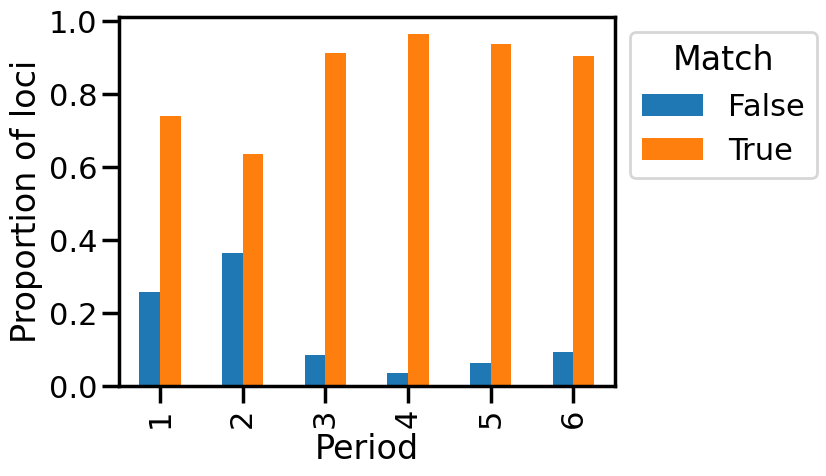

In [42]:
fig = plt.figure(figsize=(6, 6))

ax = (df_calls_filt
    .query("depth_norm_ns >= 1. and depth_norm_hs >= 1.")
    .groupby(["period"])
    .value_counts(["match"], normalize=True)
    .unstack()
    .plot(kind="bar"))

_ = ax.set(
    xlabel="Period",
    ylabel="Proportion of loci"
)

_ = ax.get_legend().set(bbox_to_anchor=(1, 1), title="Match")

In [13]:
df_calls_filt[~df_calls_filt["match"]]

,str_id,period,frequencies_ns,genotype_ns,frequencies_hs,genotype_hs,in_dup,match
1,chr01_35829,2,"{5: 6, 6: 4}","[5, 5, 6]",{5: 9},"[5, 5, 5]",False,False
5,chr01_40927,1,"{10: 5, 12: 3}","[10, 10, 12]","{10: 14, 12: 26}","[10, 12, 12]",False,False
29,chr01_85489,2,"{6: 17, 8: 2}","[6, 6, 6]","{6: 13, 8: 6}","[6, 6, 8]",False,False
37,chr01_87258,2,"{2: 2, 5: 4, 6: 9}","[5, 6, 6]","{2: 3, 5: 3, 6: 19}","[2, 6, 6]",False,False
41,chr01_127739,2,"{4: 3, 5: 1, 6: 9}","[4, 6, 6]","{4: 2, 5: 2, 6: 18}","[6, 6, 6]",False,False
...,...,...,...,...,...,...,...,...
132847,chr11_34518613,2,"{8: 1, 9: 3, 10: 18, 19: 1, 20: 2, 21: 1}","[9, 10, 10]","{9: 4, 10: 18, 11: 1, 19: 2, 20: 5, 21: 2, 22: 1}","[10, 10, 20]",False,False
132852,chr11_34535120,3,"{7: 7, 22: 1}","[7, 7, 7]","{7: 5, 22: 2}","[7, 7, 22]",False,False
132874,chr11_34574619,2,"{10: 8, 12: 1, 14: 3, 16: 1}","[10, 10, 14]","{10: 4, 14: 7, 15: 2, 16: 5}","[10, 14, 16]",False,False
132875,chr11_34582563,2,"{8: 1, 11: 5, 12: 2}","[11, 11, 12]","{8: 1, 10: 1, 11: 4, 12: 5}","[11, 12, 12]",False,False


In [14]:
print(df_calls_filt.groupby("in_dup").value_counts(["match"], normalize=False))
print(df_calls_filt.groupby("in_dup").value_counts(["match"], normalize=True))
print(df_calls_filt.query("period > 2").groupby("in_dup").value_counts(["match"], normalize=False))
print(df_calls_filt.query("period > 2").groupby("in_dup").value_counts(["match"], normalize=True))

in_dup  match
False   True     107299
        False     23945
True    True       1343
        False       296
Name: count, dtype: int64
in_dup  match
False   True     0.817554
        False    0.182446
True    True     0.819402
        False    0.180598
Name: proportion, dtype: float64
in_dup  match
False   True     61263
        False     4373
True    True       803
        False       55
Name: count, dtype: int64
in_dup  match
False   True     0.933375
        False    0.066625
True    True     0.935897
        False    0.064103
Name: proportion, dtype: float64


In [15]:
df_calls_filt.query("in_dup and not match").head(10)

,str_id,period,frequencies_ns,genotype_ns,frequencies_hs,genotype_hs,in_dup,match
17506,chr02_28008663,2,"{9: 6, 11: 5, 12: 10}","[9, 11, 12, 12]","{9: 6, 12: 21, 13: 1}","[9, 12, 12, 12]",True,False
17521,chr02_28027755,1,"{10: 23, 11: 16, 15: 1}","[10, 10, 11, 11]","{10: 21, 11: 7, 12: 1, 15: 1}","[10, 10, 10, 11]",True,False
17523,chr02_28045164,2,"{6: 12, 14: 9, 15: 13, 16: 1, 17: 5}","[6, 14, 15, 17]","{6: 7, 14: 3, 15: 15, 16: 2, 17: 5}","[6, 15, 15, 17]",True,False
17527,chr02_28065783,4,"{4: 5, 5: 1}","[4, 4, 4, 5]","{4: 3, 6: 1}","[4, 4, 4, 6]",True,False
17535,chr02_28083492,2,"{12: 2, 13: 15, 14: 3, 15: 6}","[13, 13, 14, 15]","{11: 1, 12: 2, 13: 11, 14: 3, 15: 2, 16: 2}","[13, 13, 14, 16]",True,False
17539,chr02_28089215,2,"{13: 1, 14: 13, 16: 8}","[14, 14, 16, 16]","{13: 1, 14: 22, 15: 3, 16: 9, 17: 1}","[14, 14, 14, 16]",True,False
17543,chr02_28108539,1,"{10: 2, 11: 34, 12: 4, 13: 10, 14: 4}","[11, 11, 11, 13]","{11: 18, 12: 2, 13: 15, 14: 12, 15: 2}","[11, 11, 13, 14]",True,False
17546,chr02_28126266,4,"{2: 28, 4: 17}","[2, 2, 4, 4]","{2: 38, 4: 11}","[2, 2, 2, 4]",True,False
17562,chr02_28155116,1,"{9: 6, 11: 2, 13: 1}","[9, 9, 9, 11]","{9: 6, 10: 1, 11: 7, 12: 4, 13: 3}","[9, 11, 12, 13]",True,False
17578,chr02_28190444,1,"{9: 1, 10: 14}","[10, 10, 10, 10]","{9: 5, 10: 10}","[9, 10, 10, 10]",True,False


In [16]:
df_calls_filt.query("str_id == 'chr02_28027684'")

,str_id,period,frequencies_ns,genotype_ns,frequencies_hs,genotype_hs,in_dup,match
17520,chr02_28027684,1,"{11: 15, 16: 4, 17: 16, 18: 2, 19: 6}","[11, 17, 17, 19]","{10: 1, 11: 7, 12: 2, 14: 1, 16: 3, 17: 17, 18...","[11, 17, 17, 19]",True,True


In [17]:
print((df_calls_filt[df_calls_filt["in_dup"]]
 .assign(n_distinct_ns = lambda x: [len(set(i)) for i in x["genotype_ns"]])["n_distinct_ns"]
 .value_counts()))


(df_calls_filt[df_calls_filt["in_dup"]]
 .assign(n_distinct_ns = lambda x: [len(set(i)) for i in x["genotype_ns"]])
 .query("n_distinct_ns == 3")).head(30)


n_distinct_ns
1    949
2    556
3    122
4     12
Name: count, dtype: int64


,str_id,period,frequencies_ns,genotype_ns,frequencies_hs,genotype_hs,in_dup,match,n_distinct_ns
17506,chr02_28008663,2,"{9: 6, 11: 5, 12: 10}","[9, 11, 12, 12]","{9: 6, 12: 21, 13: 1}","[9, 12, 12, 12]",True,False,3
17520,chr02_28027684,1,"{11: 15, 16: 4, 17: 16, 18: 2, 19: 6}","[11, 17, 17, 19]","{10: 1, 11: 7, 12: 2, 14: 1, 16: 3, 17: 17, 18...","[11, 17, 17, 19]",True,True,3
17531,chr02_28069574,2,"{11: 1, 12: 8, 13: 3, 14: 12, 15: 2, 16: 1}","[12, 13, 14, 14]","{11: 2, 12: 4, 13: 7, 14: 14, 15: 2}","[12, 13, 14, 14]",True,True,3
17535,chr02_28083492,2,"{12: 2, 13: 15, 14: 3, 15: 6}","[13, 13, 14, 15]","{11: 1, 12: 2, 13: 11, 14: 3, 15: 2, 16: 2}","[13, 13, 14, 16]",True,False,3
17618,chr02_28281890,2,"{7: 5, 8: 4, 9: 26, 11: 2, 12: 11}","[7, 9, 9, 12]","{7: 3, 8: 1, 9: 25, 11: 3, 12: 5, 13: 2}","[9, 9, 9, 12]",True,False,3
17642,chr02_28329504,3,"{5: 1, 6: 19, 7: 12, 10: 4, 14: 10}","[6, 6, 7, 14]","{6: 7, 7: 13, 10: 5, 14: 12}","[6, 7, 10, 14]",True,False,3
17658,chr02_28370593,2,"{9: 7, 12: 4, 13: 10, 15: 1}","[9, 12, 13, 13]","{9: 6, 12: 4, 13: 19, 14: 1, 15: 6}","[9, 13, 13, 15]",True,False,3
17665,chr02_28389767,2,"{9: 1, 10: 4, 11: 13, 12: 3, 14: 3, 15: 3, 16:...","[10, 11, 16, 16]","{10: 1, 11: 15, 12: 1, 14: 1, 15: 5, 16: 31}","[11, 15, 16, 16]",True,False,3
17680,chr02_28432520,2,"{11: 7, 17: 1, 18: 2, 19: 4}","[11, 11, 18, 19]","{11: 11, 18: 1, 19: 17}","[11, 11, 19, 19]",True,False,3
17681,chr02_28437846,2,"{15: 1, 16: 8, 17: 13, 18: 1, 19: 2, 20: 3}","[16, 17, 17, 20]","{14: 1, 16: 3, 17: 13, 18: 1, 20: 10, 21: 2}","[16, 17, 17, 20]",True,True,3
